## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

## Setup and Imports

- Installing Hugging Face's nlp package
- Importing libraries

In [ ]:
!pip install nlp

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.9.2


## Data Import
- Creating train, validation and test sets
- Extracting tweets and labels from the examples

In [3]:
dataset = nlp.load_dataset('emotion')
train = dataset['train']
test = dataset['test']
val = dataset['validation']

In [4]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
def get_tweets(data):
  tweets = [x['text'] for x in data]
  emotions = [x['label'] for x in data]
  return tweets, emotions

tweets, labels = get_tweets(train)

In [6]:
print('the tweets reads :' +tweets[2] + '  ....and the corresponding emotion is : ' +labels[2])

the tweets reads :im grabbing a minute to post i feel greedy wrong  ....and the corresponding emotion is : anger


##  Tokenizer

- Tokenizing the tweets

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer  = Tokenizer(num_words = 10000, oov_token = '<UKN>')
tokenizer.fit_on_texts(tweets)
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

## Padding and Truncating Sequences

- Checking length of the tweets
-  Creating padded sequences

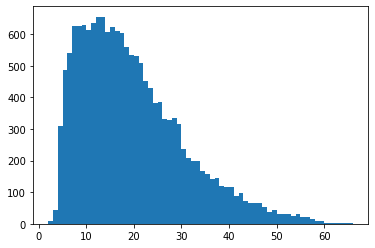

In [8]:
x= [len(x.split(' ')) for x in tweets]
plt.hist(x, bins = len(set(x)))
plt.show()

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length = 50
def tweets_formating(data):
  sequence = tokenizer.texts_to_sequences(data)
  padded = pad_sequences(sequence, padding = 'post', truncating= 'post', maxlen=max_length)
  return padded

padded_training_data = tweets_formating(tweets)
padded_training_data[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Preparing the Labels

- Creating classes to index and index to classes dictionaries
- Converting text labels to numeric labels

In [10]:
classes = set(labels)
print(classes)

{'sadness', 'fear', 'anger', 'surprise', 'joy', 'love'}


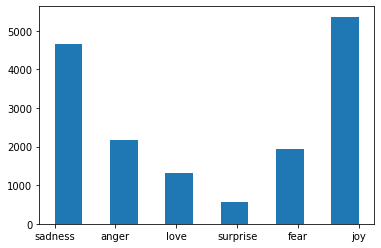

In [11]:
plt.hist(labels, bins = 11)
plt.show()

In [12]:
class_to_num = dict((j,i) for i,j in enumerate(classes))
num_to_classes = dict((k,v) for v, k in class_to_num.items())

In [13]:
labels_to_ids = lambda labels:[class_to_num.get(x) for x in labels]
train_labels = labels_to_ids(labels)
print(train_labels[2])

2


## Creating the Model


In [14]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(10000, 16, input_length = max_length),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences = True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                                    tf.keras.layers.Dense(6, activation = 'softmax')
])

model.compile(
               loss='sparse_categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Training the Model


In [15]:
val_tweets , val_labels = get_tweets(val)
val_seq = tweets_formating(val_tweets)
val_labels = labels_to_ids(val_labels)

In [16]:
array_input = np.array(padded_training_data)
array_labels = np.array(train_labels)
array_val = np.array(val_seq)
array_val_labels = np.array(val_labels)

In [17]:
N = model.fit(
    array_input, array_labels, 
    validation_data = (array_val,array_val_labels ),
    epochs=20,
    callbacks=[
                tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
                ]
)

Epoch 1/20
500/500 [==============================] - 27s 29ms/step - loss: 1.2765 - accuracy: 0.5063 - val_loss: 0.8053 - val_accuracy: 0.6985
Epoch 2/20
500/500 [==============================] - 8s 16ms/step - loss: 0.5454 - accuracy: 0.8119 - val_loss: 0.5626 - val_accuracy: 0.7960
Epoch 3/20
500/500 [==============================] - 7s 13ms/step - loss: 0.3147 - accuracy: 0.8908 - val_loss: 0.4408 - val_accuracy: 0.8520
Epoch 4/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2004 - accuracy: 0.9343 - val_loss: 0.4488 - val_accuracy: 0.8705
Epoch 5/20
500/500 [==============================] - 6s 13ms/step - loss: 0.1376 - accuracy: 0.9565 - val_loss: 0.4058 - val_accuracy: 0.8775
Epoch 6/20
500/500 [==============================] - 6s 13ms/step - loss: 0.1079 - accuracy: 0.9668 - val_loss: 0.4028 - val_accuracy: 0.8825
Epoch 7/20
500/500 [==============================] - 6s 12ms/step - loss: 0.0920 - accuracy: 0.9705 - val_loss: 0.3906 - val_accuracy: 0.892

## Evaluating the Model

- Visualizing training history
- Prepraring a test set
- A look at all predictions on the test set

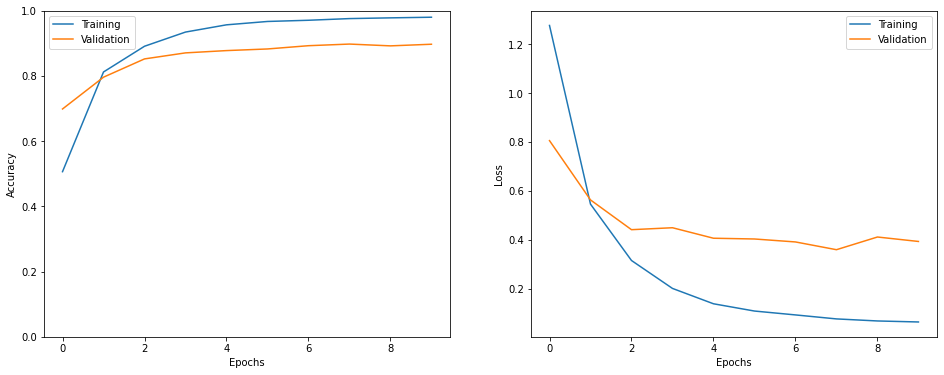

In [18]:
show_history(N)

In [19]:
test_tweets , test_labels = get_tweets(test)
test_seq = tweets_formating(test_tweets)
test_labels = labels_to_ids(test_labels)

test_tweet = np.array(test_seq)
test_labels = np.array(test_labels)

In [20]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.3891 - accuracy: 0.8855


In [21]:
preds = np.argmax(model.predict(test_seq), axis=1)

63/63 [==============================] - 2s 5ms/step


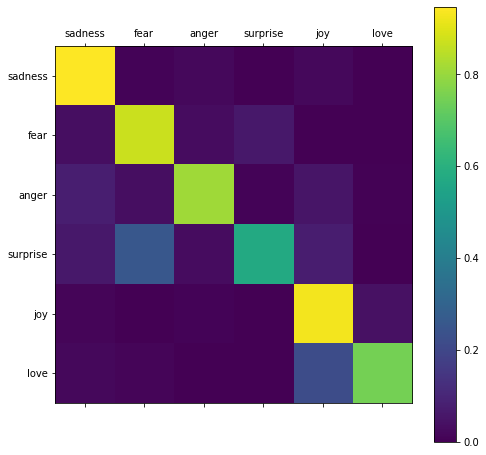

In [22]:
show_confusion_matrix (test_labels, preds, list(classes))